# Amazon Bedrock Knowledge Bases - Audio and Video Data Preparation using Amazon Bedrock Data Automation

# Introduction

This module demonstrates how to build a Multimodal Retrieval-Augmented Generation (RAG) application using Amazon Bedrock Data Automation (BDA) and Bedrock Knowledge Bases (KB). The application is designed to analyze and generate insights from multi-modalal data, including video and audio data. By incorporating contextual information from your own data sources with BDA, you can create highly accurate and secure intelligent search Generative AI applications.

In this notebook, it shows the first step of building this intelligent search application: how to efficiently process video and audio data by using BDA to generate contextual outputs for KB embedding.

With the latest integration between BDA and Amazon Bedrock Knowledge Bases, you can specify BDA as parser of your data source for Bedrock Knowledge Bases.

## Key Features

- Amazon Bedrock Data Automation (BDA): A managed service that automatically extracts content from multimodal data. BDA streamlines the generation of valuable insights from unstructured multimodal content such as documents, images, audio, and videos through a unified multi-modal inference API.
  
- Bedrock KB to build a RAG solution with BDA: Amazon Bedrock KB extract multi-modal content using BDA, generating semantic embeddings using the selected embedding model, and storing them in the chosen vector store. This enables users to retrieve and generate answers to questions derived not only from text but also from image, video and audio data. Additionally, retrieved results include source attribution for visual data, enhancing transparency and building trust in the generated outputs.

## Prerequisites
Please make sure to enable `Anthropic Claude 3 Sonnet` , `Amazon Nova Micro` and  `Titan Text Embeddings V2` model access in Amazon Bedrock Console

You need to have suitable IAM role permission to run this notebook. For IAM role, choose either an existing IAM role in your account or create a new role. The role must the necessary permissions to invoke the BDA, Bedrock KB, create IAM roles, SageMaker and S3 APIs.

Note: The AdministratorAccess IAM policy can be used, if allowed by security policies at your organization.

<div class="alert alert-block alert-info">
<b>Note:</b> Please run the notebook cell one at a time instead of using "Run All Cells" option.
</div>

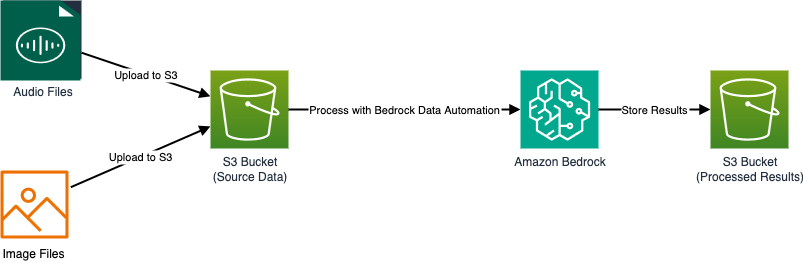

In [18]:
from PIL import Image
from IPython.display import display

# Just use the filename
img = Image.open('A&V_BDA.png')
display(img)

# Setup notebook and boto3 clients

In this step, we will import some necessary libraries that will be used throughout this notebook. To use Amazon Bedrock Data Automation (BDA) with boto3, you'll need to ensure you have the latest version of the AWS SDK for Python (boto3) installed. Version Boto3 1.35.96 of later is required.

Note: At time of Public Preview launch, BDA is available in us-west-2 only.

In [2]:
%pip install --upgrade pip --quiet
%pip install -r ../requirements.txt --no-deps -U --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [4]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-info">
<b>Note:</b> In this workshop, a new S3 bucket following the naming convention "kb-bda-multimodal-datasource-{account_id}" will be used, and the input and output will be saved under a folder called "bda" in the default bucket.
</div>

In [5]:
import boto3
from botocore.exceptions import ClientError
import json, uuid
from datetime import datetime
import time
from time import sleep
import random
from tqdm import tqdm
from pathlib import Path
from IPython.display import JSON, IFrame, Audio, display, clear_output
import IPython.display as display
import logging
import sys
from pathlib import Path
import requests

# Get current path and go up two parent directories
current_path = Path().resolve()
parent_path = current_path.parent  # Go up two levels

# Add to sys.path if not already there
if str(parent_path) not in sys.path:
    sys.path.append(str(parent_path))

# Now you can import from utils
from utils.knowledge_base import BedrockKnowledgeBase


In [6]:
#Clients
suffix = random.randrange(200, 900)

sts_client = boto3.client('sts')
account_id = sts_client.get_caller_identity()["Account"]

bucket_name_kb = f'bda-kb-{suffix}-1' # replace it with your first bucket name.
region_name = "us-east-1" # can be removed ones BDA is GA and available in other regions.
region = region_name

s3_client = boto3.client('s3', region_name=region_name)

bda_client = boto3.client('bedrock-data-automation', region_name=region_name)
bda_runtime_client = boto3.client('bedrock-data-automation-runtime', region_name=region_name)

bedrock_agent_client = boto3.client('bedrock-agent')
bedrock_agent_runtime_client = boto3.client('bedrock-agent-runtime') 

logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

In [7]:
# Function to check if the bucket exists, if not, create the data_bucket
from utils.knowledge_base_operators import bucket_exists
            
# Create S3 bucket for the KB if it doesn't exist
if not bucket_exists(bucket_name_kb):
    print(f"Bucket '{bucket_name_kb}' does not exist. Creating it now...")
    if region == "us-east-1":
        s3_client.create_bucket(Bucket=bucket_name_kb)
    else:
        s3_client.create_bucket(
            Bucket=bucket_name_kb,
            CreateBucketConfiguration={'LocationConstraint': region}
        )
    print(f"Bucket '{bucket_name_kb}' created successfully.")
else:
    print(f"Bucket '{bucket_name_kb}' already exists.")


bucket_name_input = f's3://{bucket_name_kb}/bda/input'      # DBA input path
bucket_name_output = f's3://{bucket_name_kb}/bda/output'    # DBA output path

[2025-09-18 23:40:57,414] p8500 {credentials.py:1143} INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Bucket 'bda-kb-600-1' does not exist. Creating it now...
Bucket 'bda-kb-600-1' created successfully.


## Create a BDA project
To start a BDA job, you need a BDA project, which organizes both standard and custom output configurations. This project is reusable, allowing you to apply the same configuration to process multiple video/audio files that share the same settings.

In [9]:
project_name= f'bda-kb-project-{str(uuid.uuid4())[0:4]}'

# delete project if it already exists
projects_existing = [project for project in bda_client.list_data_automation_projects()["projects"] if project["projectName"] == project_name]
if len(projects_existing) >0:
    print(f"Deleting existing project: {projects_existing[0]}")
    bda_client.delete_data_automation_project(projectArn=projects_existing[0]["projectArn"])

In [10]:
#BDA API standard output schema
response = bda_client.create_data_automation_project(
    projectName=project_name,
    projectDescription='BDA video processing project',
    projectStage='DEVELOPMENT',
    standardOutputConfiguration={
        "video": {
            "extraction": {
                "category": {
                    "state": "ENABLED",
                    "types": ["CONTENT_MODERATION", "TEXT_DETECTION", "TRANSCRIPT"]
                },
                "boundingBox": {"state": "ENABLED"}
            },
            "generativeField": {
                "state": "ENABLED",
                "types": ["VIDEO_SUMMARY", "CHAPTER_SUMMARY", "IAB"]
            }
        },
        "audio": {
            "extraction": {
                "category": {
                    "state": "ENABLED", 
                    "types": ["AUDIO_CONTENT_MODERATION", "TOPIC_CONTENT_MODERATION", "TRANSCRIPT"]
                }
            },
            "generativeField": {
                "state": "ENABLED",
                "types": ["AUDIO_SUMMARY", "TOPIC_SUMMARY", "IAB"]
            }
        }
    }
)

In [11]:
kb_project_arn = response.get("projectArn")
print("BDA kb project ARN:", kb_project_arn)

BDA kb project ARN: arn:aws:bedrock:us-east-1:788392149802:data-automation-project/7ea0455fdc2e


In [12]:
import requests
import tempfile
from pydub import AudioSegment
import os

# URL of the audio file
url = "https://s2.q4cdn.com/299287126/files/doc_financials/2024/q3/Amazon-Quarterly-Earnings-Report-Q3-2024-Full-Call-v2.wav"

# Create a temporary directory to store the files
with tempfile.TemporaryDirectory() as temp_dir:
    # Download the file
    print("Downloading audio file...")
    response = requests.get(url)
    temp_input_path = os.path.join(temp_dir, "original.wav")
    
    # Save the downloaded file
    with open(temp_input_path, 'wb') as f:
        f.write(response.content)
    
    # Load the audio file
    print("Processing audio file...")
    audio = AudioSegment.from_wav(temp_input_path)
    
    # Calculate duration in milliseconds (11 minutes and 2 seconds = 662 seconds)
    target_duration = 662 * 1000  # Convert to milliseconds
    
    # Trim the audio
    trimmed_audio = audio[:target_duration]
    
    # Save the trimmed audio to a temporary file
    temp_output_path = os.path.join(temp_dir, "trimmed.wav")
    trimmed_audio.export(temp_output_path, format="wav")
    
    # Upload the trimmed file to S3
    print("Uploading trimmed audio to S3...")
    object_name = "bda/input/earnings-call-q3-2024-trimmed.wav"
    
    with open(temp_output_path, 'rb') as file:
        s3_client.upload_fileobj(
            file,
            bucket_name_kb,
            object_name
        )

print("Process completed successfully!")


Processing audio file...
Uploading trimmed audio to S3...
Process completed successfully!


# Start BDA task audio

In [13]:
# Start BDA task audio

input_name = object_name
output_name = f'bda/output/' 

response_aud = bda_runtime_client.invoke_data_automation_async(
    inputConfiguration={'s3Uri':  f"s3://{bucket_name_kb}/{input_name}"},
    outputConfiguration={'s3Uri': f"s3://{bucket_name_kb}/{output_name}"},
    dataAutomationProfileArn= f'arn:aws:bedrock:us-east-1:{account_id}:data-automation-profile/us.data-automation-v1',
    dataAutomationConfiguration={
        'dataAutomationProjectArn': kb_project_arn,
        'stage': 'DEVELOPMENT'
    })
response_aud

{'invocationArn': 'arn:aws:bedrock:us-east-1:788392149802:data-automation-invocation/f0de93cb-ff7d-424e-bbbd-d5d544206148',
 'ResponseMetadata': {'RequestId': '708edbb0-7bf2-4ac1-b8a5-5fcf1f1cd354',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 18 Sep 2025 23:45:46 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '122',
   'connection': 'keep-alive',
   'x-amzn-requestid': '708edbb0-7bf2-4ac1-b8a5-5fcf1f1cd354'},
  'RetryAttempts': 0}}

In [14]:
invocation_audio_arn = response_aud.get("invocationArn")
print("BDA audio task started:", invocation_audio_arn)

BDA audio task started: arn:aws:bedrock:us-east-1:788392149802:data-automation-invocation/f0de93cb-ff7d-424e-bbbd-d5d544206148


### We can monitor the progress status of BDA task execution, by running the code cell below

In [15]:
statusAudio, status_aud_response = None, None
while (statusAudio not in ["Success","ServiceError","ClientError"]) and (statusAudio not in ["Success","ServiceError","ClientError"]):
    status_aud_response = bda_runtime_client.get_data_automation_status(
        invocationArn=invocation_audio_arn
    )
    statusAudio = status_aud_response.get("status")
    clear_output(wait=True)
   # print(f"{datetime.now().strftime('%H:%M:%S')} : BDA kb audio task: {statusAudio}")
    
    clear_output(wait=True)
    print(f"{datetime.now().strftime('%H:%M:%S')} : "\
          f"BDA kb audio task: {statusAudio}")
    time.sleep(5)

output_aud_config = status_aud_response.get("outputConfiguration",{}).get("s3Uri")
print("Ouput configuration file:", output_aud_config)

23:46:50 : BDA kb audio task: Success
Ouput configuration file: s3://bda-kb-600-1/bda/output//f0de93cb-ff7d-424e-bbbd-d5d544206148/job_metadata.json


# Examine the BDA output for the processed audio file

In [16]:
out_aud_loc = status_aud_response['outputConfiguration']['s3Uri'].split("/job_metadata.json", 1)[0].split(bucket_name_kb+"/")[1]
out_aud_loc += "/0/standard_output/0/result.json"
print(out_aud_loc)
s3_client.download_file(bucket_name_kb, out_aud_loc, 'result_aud.json')

bda/output//f0de93cb-ff7d-424e-bbbd-d5d544206148/0/standard_output/0/result.json


In [17]:
data_vid = json.load(open('result_aud.json'))
print(data_vid["audio"]["summary"])

Amazon reported strong Q3 2024 financial results, with $158.9 billion in revenue (up 11% year-over-year) and $17.4 billion in operating income (up 56% year-over-year). Key highlights include:

- Stores business growth of 9% in North America and 12% internationally, driven by factors like broad selection, low prices, fast delivery, and Prime member benefits.
- Initiatives to lower cost to serve, including improving inventory placement, expanding same-day delivery, and advancing fulfillment center automation and robotics.
- 18.8% year-over-year growth in the advertising business to $14.3 billion, with opportunities in sponsored products, Prime Video ads, and AI-powered creative tools.
- 19.1% year-over-year growth in AWS to a $110 billion annualized run rate, driven by enterprise cloud adoption, new product launches, and progress in AI capabilities.


## Conclusion

Congrats! By following this notebook, you finished the BDA processing of video and audio files, and you are ready to build a robust Multimodal RAG application tailored to your specific needs in the next notebook: 02_audio_video_rag_kb.